# Introducción

## Objetivo de este programa

- Cargar los datos de entrenamiento y validación.
- Manipular los datos para entrenar una Red Neuronal Artificial Convolucional Multiclase, en adelante simplemente "*modelo*".
- Definir, compilar y entrenar el modelo.
- Caracterizar el rendimiento del modelo.
- Descargar la version del modelo más exitosa.

## Por qué utilizamos GoogleColab para realizar el entrenamiento?

Hay tres motivos muy releventes, uno es que es independiente del sistema operativo que haya sido instalado en el ordenador local,
 el segundo es que nos ahorra la instalación de numerosos paquetes externos y en tercer lugar nos proporciona recursos de aceleración de hardware gratuitos (más sobre eso adelante).\
 Además al ser interactivo permite agregar comentarios, notas y explicaciones que en este contexto resultan sumamente útiles.




In [58]:
# -- Libraries (NO BORRAR!!)
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

## Guía para armar el conjunto de datos

### Crear localmente la muestra

Supongamos que uno quiere catalogar una imágen médica como perteneciente a alguna de las siguientes 3 clases:\
 cancer, hernia, fractura,\
y supongamos que uno cuenta con 500 imágenes de cada una de las clases.

Entonces para armar la muestra (o conjunto de datos) creamos una carpeta madre que llamaremos "*dataset*" y adentro de ella 3 subcarpetas con los nombres de cada clase.
Luego agregaremos a cada subcarpeta todas las imágenes que se correspondan con dicha categoría.
Debería verse de la siguiente manera:
```
\dataset\
...\cancer\
    ...img1.jpg
    ...img2.jpg
    ...
...\hernia\
    ...img1.jpg
    ...img2.jpg
    ...
...\fractura\
    ...img1.jpg
    ...img2.jpg
    ...    
```

### Subir la muestra a GoogleDrive
Luego debemos hacer que la muestra sea visible para este código.
Hay varias formas de hacerlo:
- A) Desde GoogleDrive:
    1. subir la carpeta a tu Drive
    2. montar el drive a GoogleColab:
    > 
    ```python
    from google.colab import drive
    drive.mount('/gdrive')
    ```
    3. establecer la dirección a la carpeta como:\
    ```python
    data_dir = "/gdrive/My Drive/<path_to_dataset>"
    ```
    donde hay que reemplazar `<path_to_dataset>` por la direccion exacta dentro de Drive.
    En el ejemplo anterior, si hemos subido la carpeta "dataset" a "Mi unidad" entonces quedaria:
    ```python
    data_dir = "/gdrive/My Drive/dataset"
    ```

- B) Desde el sistema de archivos local
    1. Crear carpetas en GoogleColab:
        - A la izquierda de la pantalla seleccionar el icono de "Archivos" o "Files".
        - Click Derecho -> Nueva Carpeta: darle el nombre "dataset"
        - Entrar en `dataset` y crear las subcarpetas para cada clase.
        - Si presiona la tecla F5, vera que se actualiza la pantalla con las nuevas carpetas.

    2. Subir archivos a las subcarpetas correspondientes:
        - seleccione cada subcarpeta y seleccione el icono de los 3 puntos verticales (opciones).
        - eliga la opcion "Upload" o "Subir".
        - navegue por su sistema de archivos hasta la carpeta que contiene las imagenes que se corresponden con la clase a cargar y selecciones todos los archivos.
        - repita para todas las clases.
    3. Elegir la carpeta `dataset`:
        ```python
        data_dir = 'dataset'
        ```

Yo recomiendo la opcion A)

In [59]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


En la proxima celda defina `data_dir`

In [ ]:
data_dir = ""

Corrobore que la direccion fue ingresada y definida correctamente

In [60]:
os.path.exists(data_dir)


True


## A modo de ejemplo utilizaremos 5 clases de flores.

Para ilustrar como funciona el codigo voy a descargar una muestra de 5 clases de flores.
Si llevo a cabo los pasos mencionados anteriormente para crear y subir el conjunto de datos,
entonces la unica modificacion que hay que realizar es definir la direccion al conjunto de datos.

Definicion de parametros

In [63]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

/root/.keras/datasets/flower_photos


numero total de imagenes en cada subcarpeta 3670
Una rosa -->


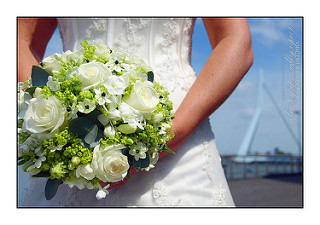

In [64]:
# -- check dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"numero total de imagenes en cada subcarpeta {image_count}")

print("Una rosa -->")
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# Definir Parametros

In [ ]:
batch_size = 32     # tamano del batch de entrenamiento
img_height = 180    # altura de la imagen
img_width = 180     # ancho de la imagen
epochs = 15         # cantidad de epocas de entrenamiento

# Levantar Imagenes

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="rgb")
  

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="rgb")

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Obtenemos los nombres de las distintas clases

In [35]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


A continuacion mejoramos el rendimiento de carga de archivos

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Definimos el modelo

In [37]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Ahora entrenamos el modelo,
se guardará solo el modelo que mejor se desempeñe según la función de pérdida,
dado que al contar con pocos datos el mayor reto resulta el sobreajuste.

In [39]:
checkpoint_filepath = 'output_model'
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [40]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoints]
)

Epoch 1/15
92/92 [==============================] - 12s 57ms/step - loss: 1.4560 - accuracy: 0.3566 - val_loss: 1.0499 - val_accuracy: 0.5899
INFO:tensorflow:Assets written to: output_model/assets
Epoch 2/15
92/92 [==============================] - 4s 39ms/step - loss: 0.9648 - accuracy: 0.6129 - val_loss: 0.9111 - val_accuracy: 0.6526
INFO:tensorflow:Assets written to: output_model/assets
Epoch 3/15
92/92 [==============================] - 4s 39ms/step - loss: 0.7947 - accuracy: 0.7028 - val_loss: 0.8624 - val_accuracy: 0.6512
INFO:tensorflow:Assets written to: output_model/assets
Epoch 4/15
92/92 [==============================] - 4s 41ms/step - loss: 0.5841 - accuracy: 0.7857 - val_loss: 0.9043 - val_accuracy: 0.6580
Epoch 5/15
92/92 [==============================] - 4s 39ms/step - loss: 0.3444 - accuracy: 0.8835 - val_loss: 0.9798 - val_accuracy: 0.6757
Epoch 6/15
92/92 [==============================] - 4s 39ms/step - loss: 0.1990 - accuracy: 0.9383 - val_loss: 1.2300 - val_accur

### Evaluando el rendimiento del modelo

A continuación graficamos la función de pérdida y la exactitud tanto para el subconjunto de entrenamiento como el de validación.

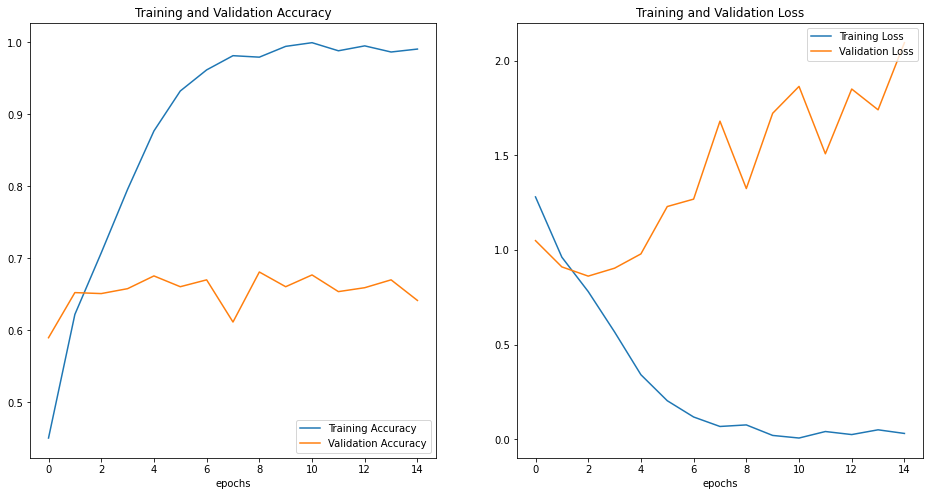

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Una vez entrenado el modelo debemos descargarlo para hacer las predicciones y poder eventualmente conectarlo a una página web.
Para ello tenemos que comprimir la carpeta con el modelo (`output_model`) y descargarla.\
A continuación hacemos justamente eso último.

In [49]:
from google.colab import files

In [48]:
# -- tar the folder
!tar -czvf output_model.tar /content/output_model
# -- download the file
files.download("output_model.tar")

INFO:tensorflow:Assets written to: testmodel/assets
tar: Removing leading `/' from member names
/content/testmodel/
/content/testmodel/variables/
/content/testmodel/variables/variables.index
/content/testmodel/variables/variables.data-00000-of-00001
/content/testmodel/assets/
/content/testmodel/saved_model.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Luego en tu máquina local, dónde descargaste el archivo `output_model.tar` debés descomprimir la carpeta mediante algún software o, en la terminal con el siguiente comando:
```shell
tar -xvf output_model.tar
```
También es importante guardar la ubicación de la carpeta, puesto que será utilizada para hacer las prediciones.